# 📊 Segment-Based Churn Definition Analysis

**هدف:** تعریف Churn مختص هر سگمنت بر اساس رفتار طبیعی خرید کاربران

**منطق:** یه کاربر که هر ۳ روز خرید می‌کرده و ۳۰ روزه نیومده با یه کاربر که هر ماه خرید می‌کرده و ۳۰ روزه نیومده خیلی فرق داره!

**مراحل:**
1. سگمنت‌بندی کاربران بر اساس Frequency
2. محاسبه میانگین فاصله خرید (avg_purchase_interval) برای هر کاربر
3. تحلیل توزیع این متغیر در هر سگمنت
4. تعریف Churn Threshold مختص هر سگمنت
5. محاسبه Churn Rate نهایی

---

## 0️⃣ Setup & Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import jdatetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot settings
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette for segments
SEGMENT_COLORS = {
    '1 Order': '#E74C3C',      # Red - one-time
    '2-4 Orders': '#F39C12',   # Orange
    '5-10 Orders': '#3498DB',  # Blue
    '11-30 Orders': '#2ECC71', # Green
    '30+ Orders': '#9B59B6'    # Purple - power users
}

print('✅ Libraries loaded successfully!')

✅ Libraries loaded successfully!


In [2]:
# Helper functions for Jalali dates
def to_jalali(date):
    """Convert Gregorian date to Jalali string format."""
    if pd.isna(date):
        return None
    if isinstance(date, str):
        date = pd.to_datetime(date)
    j_date = jdatetime.date.fromgregorian(date=date.date() if hasattr(date, 'date') else date)
    return j_date.strftime('%Y/%m/%d')

def to_jalali_year_month(date):
    """Get Jalali year-month for grouping."""
    if pd.isna(date):
        return None
    if isinstance(date, str):
        date = pd.to_datetime(date)
    j_date = jdatetime.date.fromgregorian(date=date.date() if hasattr(date, 'date') else date)
    return f"{j_date.year}-{j_date.month:02d}"

print('✅ Helper functions ready!')

✅ Helper functions ready!


## 1️⃣ Data Loading

In [3]:
# Load data
DATA_DIR = '../data'  # Adjust path as needed

orders_df = pd.read_csv(f'{DATA_DIR}/orders.csv')
crm_df = pd.read_csv(f'{DATA_DIR}/crm.csv')

# Convert dates
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])

# Merge with CRM
crm_cols = ['order_id', 'crm_delivery_request_count', 'crm_fake_delivery_request_count', 
            'rate_to_shop', 'rate_to_courier']
master_df = orders_df.merge(crm_df[crm_cols], on='order_id', how='left')

# Get date range
min_date = master_df['order_date'].min()
max_date = master_df['order_date'].max()
date_range_days = (max_date - min_date).days

print('📁 Data Loaded:')
print(f'  Orders: {len(master_df):,}')
print(f'  Users:  {master_df["user_id"].nunique():,}')
print(f'\n📅 Date Range:')
print(f'  {to_jalali(min_date)} → {to_jalali(max_date)} ({date_range_days} days)')

📁 Data Loaded:
  Orders: 2,720,059
  Users:  375,998

📅 Date Range:
  1403/12/26 → 1404/06/21 (180 days)


---
## 2️⃣ Calculate User-Level Features

In [4]:
# Sort by user and date for interval calculation
master_df = master_df.sort_values(['user_id', 'order_date'])

# Calculate days between consecutive purchases
master_df['prev_order_date'] = master_df.groupby('user_id')['order_date'].shift(1)
master_df['days_between'] = (master_df['order_date'] - master_df['prev_order_date']).dt.days

print('✅ Days between purchases calculated')
print(f'   Sample: {master_df["days_between"].dropna().head(10).tolist()}')

✅ Days between purchases calculated
   Sample: [0.0, 11.0, 37.0, 22.0, 1.0, 0.0, 8.0, 0.0, 4.0, 5.0]


In [5]:
# Aggregate to user level
user_features = master_df.groupby('user_id').agg(
    order_count=('order_id', 'count'),
    first_order_date=('order_date', 'min'),
    last_order_date=('order_date', 'max'),
    avg_purchase_interval=('days_between', 'mean'),      # میانگین فاصله خرید
    median_purchase_interval=('days_between', 'median'), # میانه فاصله خرید
    std_purchase_interval=('days_between', 'std'),       # انحراف معیار
    min_purchase_interval=('days_between', 'min'),       # کمترین فاصله
    max_purchase_interval=('days_between', 'max'),       # بیشترین فاصله
    total_complaints=('crm_delivery_request_count', 'sum'),
    avg_shop_rating=('rate_to_shop', 'mean'),
    avg_courier_rating=('rate_to_courier', 'mean')
).reset_index()

# Calculate additional features
user_features['recency'] = (max_date - user_features['last_order_date']).dt.days
user_features['tenure'] = (user_features['last_order_date'] - user_features['first_order_date']).dt.days
user_features['acquisition_month'] = user_features['first_order_date'].apply(to_jalali_year_month)

print(f'✅ User features calculated for {len(user_features):,} users')
display(user_features.head(10))

✅ User features calculated for 375,998 users


,user_id,order_count,first_order_date,last_order_date,avg_purchase_interval,median_purchase_interval,std_purchase_interval,min_purchase_interval,max_purchase_interval,total_complaints,avg_shop_rating,avg_courier_rating,recency,tenure,acquisition_month
0,1,25,2025-03-27,2025-09-02,6.62,4.00,8.34,0.00,37.00,11,4.47,4.83,10,159,1404-01
1,4,2,2025-05-03,2025-08-18,107.00,107.00,NaN,107.00,107.00,1,NaN,NaN,25,107,1404-02
2,14,4,2025-08-14,2025-08-31,5.67,8.00,4.93,0.00,9.00,0,NaN,NaN,12,17,1404-05
3,16,3,2025-06-04,2025-08-18,37.50,37.50,53.03,0.00,75.00,1,3.00,5.00,25,75,1404-03
4,40,35,2025-03-28,2025-09-06,4.76,3.00,5.56,0.00,20.00,9,4.82,5.00,6,162,1404-01
5,41,2,2025-05-17,2025-08-08,83.00,83.00,NaN,83.00,83.00,2,5.00,5.00,35,83,1404-02
6,42,4,2025-04-16,2025-09-10,49.00,9.00,71.90,6.00,132.00,2,4.00,3.00,2,147,1404-01
7,60,24,2025-03-19,2025-08-26,6.96,4.00,10.42,0.00,45.00,5,4.93,5.00,17,160,1403-12
8,63,12,2025-04-05,2025-09-09,14.27,6.00,15.87,1.00,51.00,0,NaN,NaN,3,157,1404-01
9,66,2,2025-04-30,2025-05-08,8.00,8.00,NaN,8.00,8.00,1,NaN,NaN,127,8,1404-02


---
## 3️⃣ Create Frequency-Based Segments

In [6]:
# Define segments based on order count
def assign_frequency_segment(order_count):
    if order_count == 1:
        return '1 Order'
    elif order_count <= 4:
        return '2-4 Orders'
    elif order_count <= 10:
        return '5-10 Orders'
    elif order_count <= 30:
        return '11-30 Orders'
    else:
        return '30+ Orders'

user_features['frequency_segment'] = user_features['order_count'].apply(assign_frequency_segment)

# Set order for display
segment_order = ['1 Order', '2-4 Orders', '5-10 Orders', '11-30 Orders', '30+ Orders']
user_features['frequency_segment'] = pd.Categorical(
    user_features['frequency_segment'], 
    categories=segment_order, 
    ordered=True
)

print('✅ Frequency segments assigned')

✅ Frequency segments assigned


In [7]:
# Segment distribution
print('='*70)
print('📊 Frequency Segment Distribution')
print('='*70)

segment_dist = user_features['frequency_segment'].value_counts().sort_index()
segment_pct = (segment_dist / len(user_features) * 100).round(1)

for seg in segment_order:
    count = segment_dist.get(seg, 0)
    pct = segment_pct.get(seg, 0)
    bar = '█' * int(pct / 2)
    print(f'  {seg:>15}: {count:>8,} ({pct:>5.1f}%) {bar}')

print(f'\n  {"Total":>15}: {len(user_features):>8,}')

📊 Frequency Segment Distribution
          1 Order:  168,769 ( 44.9%) ██████████████████████
       2-4 Orders:   83,619 ( 22.2%) ███████████
      5-10 Orders:   55,972 ( 14.9%) ███████
     11-30 Orders:   48,491 ( 12.9%) ██████
       30+ Orders:   19,147 (  5.1%) ██

            Total:  375,998


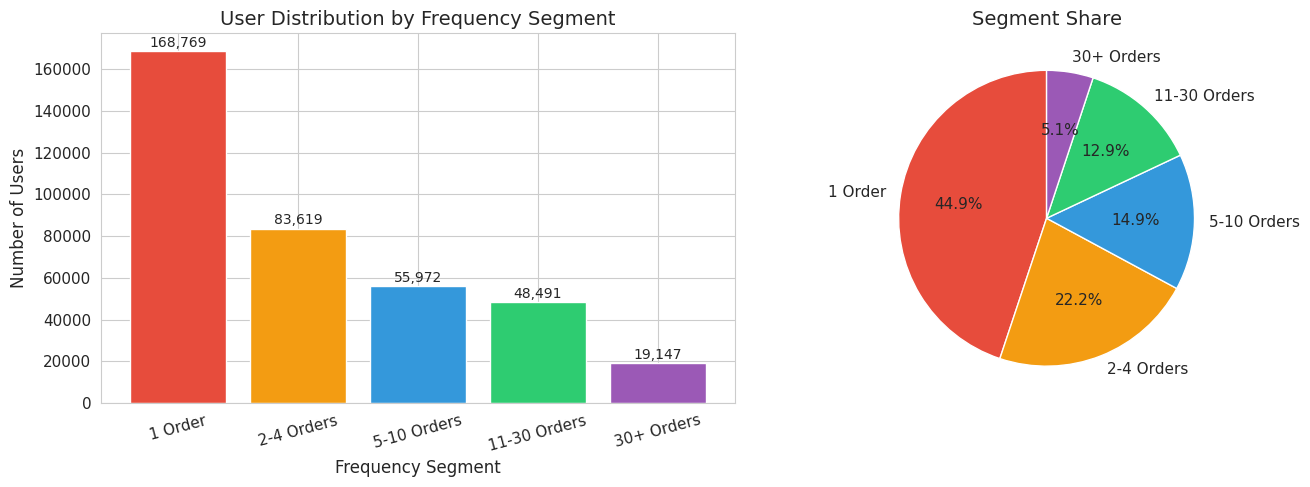

In [8]:
# Visualize segment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = [SEGMENT_COLORS[seg] for seg in segment_order]
axes[0].bar(segment_order, segment_dist.values, color=colors)
axes[0].set_xlabel('Frequency Segment')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('User Distribution by Frequency Segment')
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(segment_dist.values):
    axes[0].text(i, v + 2000, f'{v:,}', ha='center', fontsize=10)

# Pie chart
axes[1].pie(segment_dist.values, labels=segment_order, colors=colors,
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Segment Share')

plt.tight_layout()
plt.show()

---
## 4️⃣ Analyze Purchase Interval per Segment

برای هر سگمنت، توزیع میانگین فاصله خرید کاربران رو بررسی می‌کنیم

In [9]:
# Note: Users with 1 order don't have purchase interval
print('='*70)
print('📊 Average Purchase Interval by Segment')
print('='*70)
print('\n⚠️ Note: "1 Order" users have no purchase interval (only one purchase)\n')

# Filter users with 2+ orders (they have purchase intervals)
users_with_interval = user_features[user_features['order_count'] >= 2].copy()

interval_stats = users_with_interval.groupby('frequency_segment')['avg_purchase_interval'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max',
     lambda x: x.quantile(0.25),
     lambda x: x.quantile(0.75),
     lambda x: x.quantile(0.90),
     lambda x: x.quantile(0.95)]
).round(1)

interval_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'P25', 'P75', 'P90', 'P95']

display(interval_stats)

📊 Average Purchase Interval by Segment

⚠️ Note: "1 Order" users have no purchase interval (only one purchase)



,Count,Mean,Median,Std,Min,Max,P25,P75,P90,P95
frequency_segment,,,,,,,,,,
1 Order,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2-4 Orders,83619,31.20,19.30,34.80,0.00,179.00,4.50,46.00,78.00,109.00
5-10 Orders,55972,17.70,17.50,9.30,0.00,45.00,11.00,23.60,30.20,34.40
11-30 Orders,48491,8.90,8.50,3.30,0.00,18.00,6.40,11.20,13.60,14.90
30+ Orders,19147,3.50,3.50,1.20,0.00,6.00,2.60,4.50,5.10,5.40


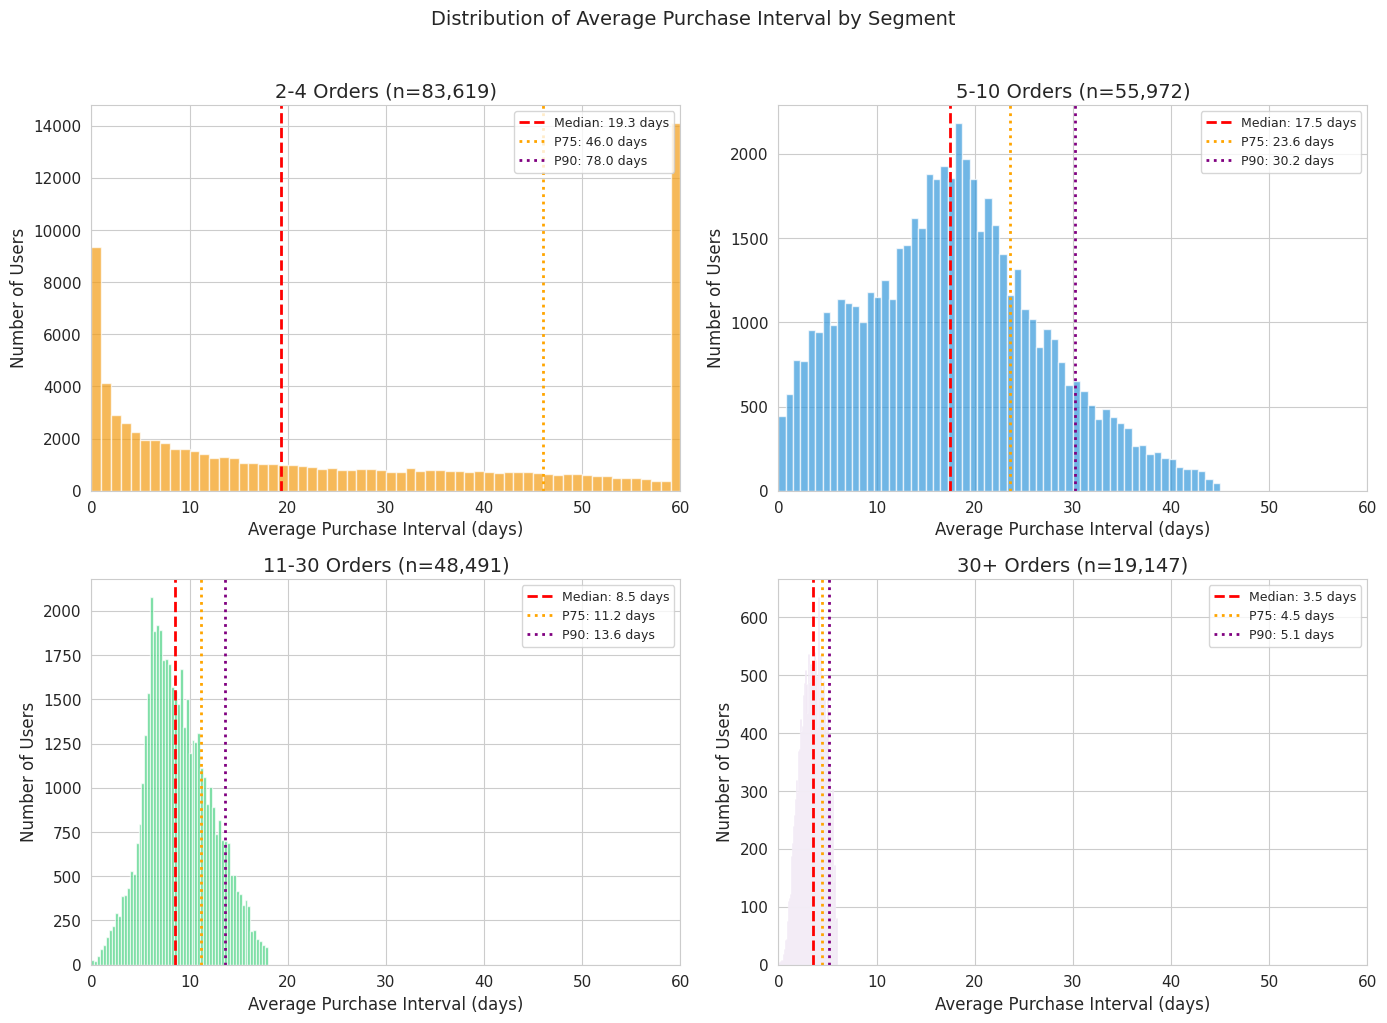

In [10]:
# Visualize purchase interval distribution by segment
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Filter out 1 Order segment (no interval)
segments_with_interval = ['2-4 Orders', '5-10 Orders', '11-30 Orders', '30+ Orders']

for idx, segment in enumerate(segments_with_interval):
    ax = axes[idx // 2, idx % 2]
    segment_data = users_with_interval[users_with_interval['frequency_segment'] == segment]['avg_purchase_interval']
    
    # Histogram
    ax.hist(segment_data.clip(upper=60), bins=60, color=SEGMENT_COLORS[segment], 
            edgecolor='white', alpha=0.7)
    
    # Add vertical lines for key statistics
    median_val = segment_data.median()
    p75_val = segment_data.quantile(0.75)
    p90_val = segment_data.quantile(0.90)
    
    ax.axvline(x=median_val, color='red', linestyle='--', linewidth=2, 
               label=f'Median: {median_val:.1f} days')
    ax.axvline(x=p75_val, color='orange', linestyle=':', linewidth=2,
               label=f'P75: {p75_val:.1f} days')
    ax.axvline(x=p90_val, color='purple', linestyle=':', linewidth=2,
               label=f'P90: {p90_val:.1f} days')
    
    ax.set_xlabel('Average Purchase Interval (days)')
    ax.set_ylabel('Number of Users')
    ax.set_title(f'{segment} (n={len(segment_data):,})')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xlim(0, 60)

plt.suptitle('Distribution of Average Purchase Interval by Segment', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

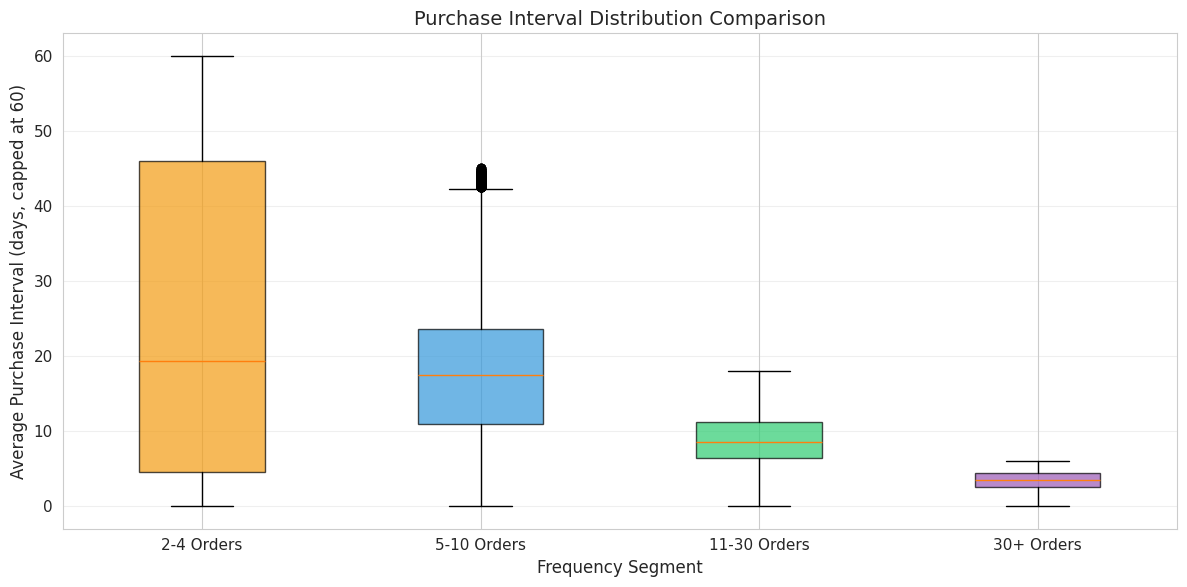

In [11]:
# Box plot comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for boxplot
box_data = [users_with_interval[users_with_interval['frequency_segment'] == seg]['avg_purchase_interval'].dropna().clip(upper=60)
            for seg in segments_with_interval]

bp = ax.boxplot(box_data, labels=segments_with_interval, patch_artist=True)

# Color the boxes
for patch, seg in zip(bp['boxes'], segments_with_interval):
    patch.set_facecolor(SEGMENT_COLORS[seg])
    patch.set_alpha(0.7)

ax.set_xlabel('Frequency Segment')
ax.set_ylabel('Average Purchase Interval (days, capped at 60)')
ax.set_title('Purchase Interval Distribution Comparison')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5️⃣ Define Segment-Specific Churn Thresholds

**منطق:** اگه کاربری از "X برابر" میانگین فاصله خریدش بگذره، احتمالاً churn شده

**رویکردهای ممکن:**
- 2x میانگین فاصله خرید
- 2x میانه فاصله خرید  
- P90 فاصله خرید (90% خریدها در این بازه انجام میشه)
- ترکیبی از بالا + حداقل threshold

In [12]:
print('='*70)
print('🎯 Calculating Segment-Specific Churn Thresholds')
print('='*70)

# Calculate thresholds for each segment
segment_thresholds = {}

for segment in segments_with_interval:
    segment_data = users_with_interval[users_with_interval['frequency_segment'] == segment]['avg_purchase_interval']
    
    median_interval = segment_data.median()
    mean_interval = segment_data.mean()
    p75_interval = segment_data.quantile(0.75)
    p90_interval = segment_data.quantile(0.90)
    
    # Different threshold strategies
    threshold_2x_median = 2 * median_interval
    threshold_2x_mean = 2 * mean_interval
    threshold_p90 = p90_interval
    threshold_2x_p75 = 2 * p75_interval
    
    segment_thresholds[segment] = {
        'median': median_interval,
        'mean': mean_interval,
        'p75': p75_interval,
        'p90': p90_interval,
        '2x_median': threshold_2x_median,
        '2x_mean': threshold_2x_mean,
        '2x_p75': threshold_2x_p75
    }

# Display as DataFrame
threshold_df = pd.DataFrame(segment_thresholds).T.round(1)
print('\n📊 Interval Statistics & Threshold Options (days):')
display(threshold_df)

🎯 Calculating Segment-Specific Churn Thresholds

📊 Interval Statistics & Threshold Options (days):


,median,mean,p75,p90,2x_median,2x_mean,2x_p75
2-4 Orders,19.30,31.20,46.00,78.00,38.70,62.50,92.00
5-10 Orders,17.50,17.70,23.60,30.20,35.00,35.40,47.10
11-30 Orders,8.50,8.90,11.20,13.60,17.10,17.80,22.30
30+ Orders,3.50,3.50,4.50,5.10,7.10,7.00,9.00


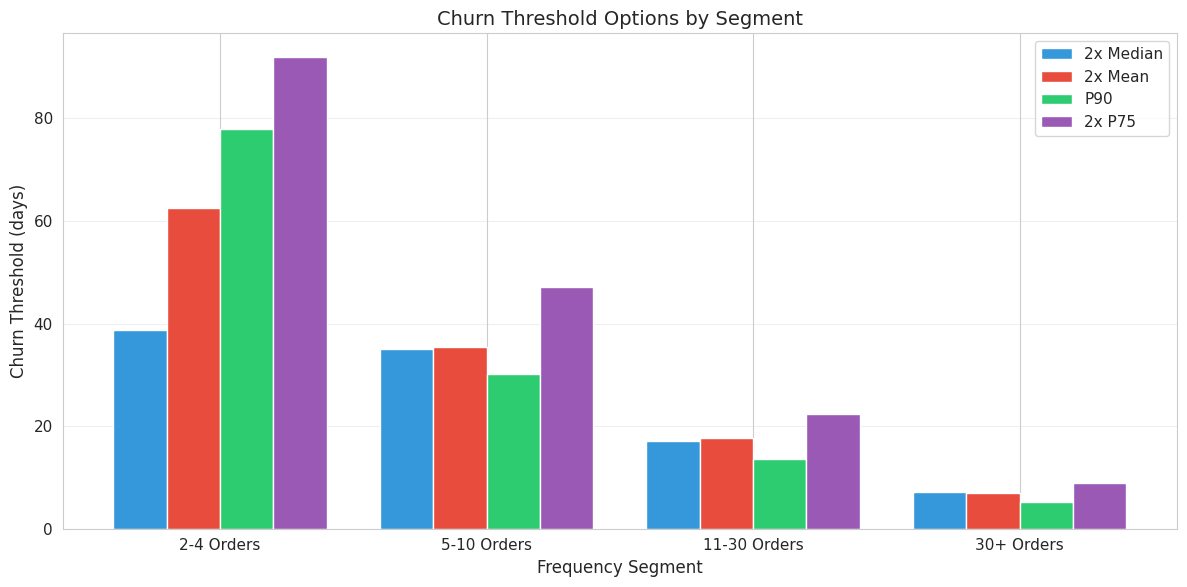

In [13]:
# Visualize threshold options
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(segments_with_interval))
width = 0.2

# Plot different threshold options
ax.bar(x - 1.5*width, [segment_thresholds[s]['2x_median'] for s in segments_with_interval], 
       width, label='2x Median', color='#3498DB')
ax.bar(x - 0.5*width, [segment_thresholds[s]['2x_mean'] for s in segments_with_interval], 
       width, label='2x Mean', color='#E74C3C')
ax.bar(x + 0.5*width, [segment_thresholds[s]['p90'] for s in segments_with_interval], 
       width, label='P90', color='#2ECC71')
ax.bar(x + 1.5*width, [segment_thresholds[s]['2x_p75'] for s in segments_with_interval], 
       width, label='2x P75', color='#9B59B6')

ax.set_xlabel('Frequency Segment')
ax.set_ylabel('Churn Threshold (days)')
ax.set_title('Churn Threshold Options by Segment')
ax.set_xticks(x)
ax.set_xticklabels(segments_with_interval)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Define final thresholds (you can adjust these based on business needs)
# Strategy: 2x median with minimum floor of 14 days and maximum cap of 90 days

MIN_THRESHOLD = 14  # Minimum 2 weeks
MAX_THRESHOLD = 90  # Maximum 3 months

final_thresholds = {}

for segment in segme    nt_order:
    if segment == '1 Order':
        # For one-time buyers, use fixed threshold based on overall behavior
        # They have no interval, so use a reasonable default
        final_thresholds[segment] = 45  # ~1.5 months
    else:
        # Use 2x median, clamped to min/max
        raw_threshold = segment_thresholds[segment]['2x_median']
        final_thresholds[segment] = max(MIN_THRESHOLD, min(MAX_THRESHOLD, raw_threshold))

print('='*70)
print('🎯 Final Segment-Specific Churn Thresholds')
print('='*70)
print(f'\nStrategy: 2x Median, clamped to [{MIN_THRESHOLD}, {MAX_THRESHOLD}] days\n')

for segment, threshold in final_thresholds.items():
    print(f'  {segment:>15}: {threshold:>5.0f} days')

🎯 Final Segment-Specific Churn Thresholds

Strategy: 2x Median, clamped to [14, 90] days

          1 Order:    45 days
       2-4 Orders:    39 days
      5-10 Orders:    35 days
     11-30 Orders:    17 days
       30+ Orders:    14 days


## 6️⃣ Apply Segment-Specific Churn Definition

In [15]:
# Apply churn definition based on segment
def is_churned(row):
    segment = row['frequency_segment']
    recency = row['recency']
    threshold = final_thresholds[segment]
    return recency > threshold

user_features['churn_threshold'] = user_features['frequency_segment'].map(final_thresholds)
user_features['is_churned'] = user_features.apply(is_churned, axis=1)

print('✅ Segment-specific churn applied')

✅ Segment-specific churn applied


In [16]:
# Churn rate by segment
print('='*70)
print('📊 Churn Rate by Segment (Segment-Specific Thresholds)')
print('='*70)

churn_by_segment = user_features.groupby('frequency_segment').agg(
    total_users=('user_id', 'count'),
    churned_users=('is_churned', 'sum'),
    threshold=('churn_threshold', 'first')
).reset_index()

churn_by_segment['churn_rate'] = (churn_by_segment['churned_users'] / churn_by_segment['total_users'] * 100).round(1)
churn_by_segment['active_users'] = churn_by_segment['total_users'] - churn_by_segment['churned_users']

display(churn_by_segment)

📊 Churn Rate by Segment (Segment-Specific Thresholds)


,frequency_segment,total_users,churned_users,threshold,churn_rate,active_users
0,1 Order,168769,125578,45.00,74.40,43191
1,2-4 Orders,83619,45514,38.67,54.40,38105
2,5-10 Orders,55972,17675,35.00,31.60,38297
3,11-30 Orders,48491,14648,17.06,30.20,33843
4,30+ Orders,19147,2384,14.00,12.50,16763


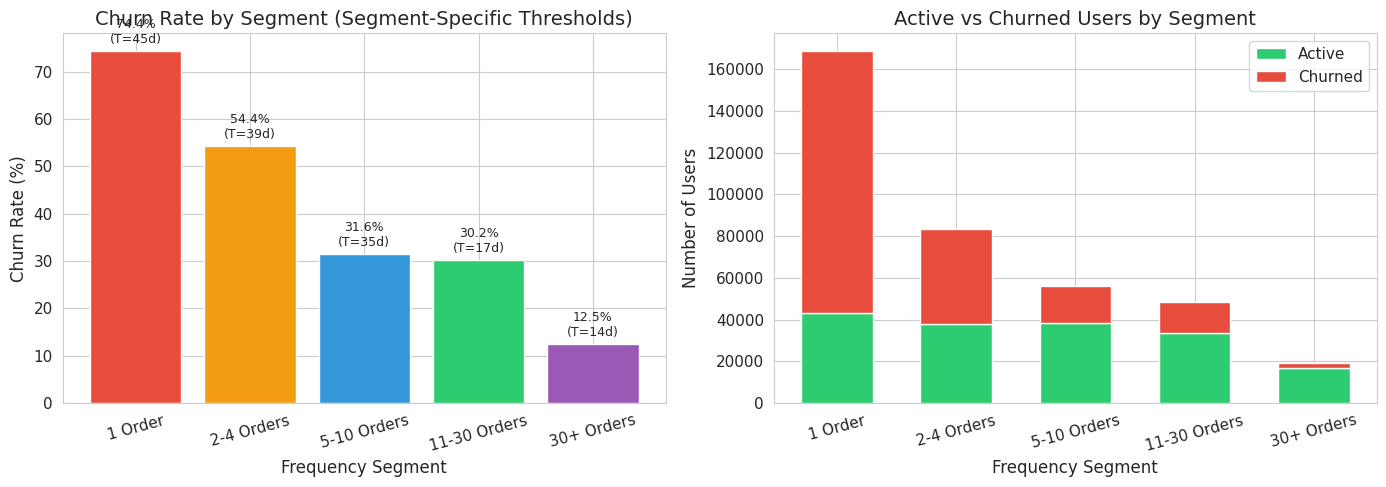

In [17]:
# Visualize churn rate by segment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Churn rate by segment
colors = [SEGMENT_COLORS[seg] for seg in churn_by_segment['frequency_segment']]
bars = axes[0].bar(churn_by_segment['frequency_segment'], churn_by_segment['churn_rate'], color=colors)
axes[0].set_xlabel('Frequency Segment')
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_title('Churn Rate by Segment (Segment-Specific Thresholds)')
axes[0].tick_params(axis='x', rotation=15)

# Add threshold labels on bars
for bar, row in zip(bars, churn_by_segment.itertuples()):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%\n(T={row.threshold:.0f}d)',
                 ha='center', va='bottom', fontsize=9)

# Right: Stacked bar - Active vs Churned
x = np.arange(len(churn_by_segment))
width = 0.6

axes[1].bar(x, churn_by_segment['active_users'], width, label='Active', color='#2ECC71')
axes[1].bar(x, churn_by_segment['churned_users'], width, bottom=churn_by_segment['active_users'],
            label='Churned', color='#E74C3C')

axes[1].set_xlabel('Frequency Segment')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Active vs Churned Users by Segment')
axes[1].set_xticks(x)
axes[1].set_xticklabels(churn_by_segment['frequency_segment'], rotation=15)
axes[1].legend()

plt.tight_layout()
plt.show()

In [18]:
# Overall churn rate with segment-specific thresholds
print('='*70)
print('📊 Overall Churn Summary')
print('='*70)

total_users = len(user_features)
total_churned = user_features['is_churned'].sum()
total_active = total_users - total_churned
overall_churn_rate = total_churned / total_users * 100

print(f'\nTotal Users:     {total_users:,}')
print(f'Active Users:    {total_active:,} ({100-overall_churn_rate:.1f}%)')
print(f'Churned Users:   {total_churned:,} ({overall_churn_rate:.1f}%)')

📊 Overall Churn Summary

Total Users:     375,998
Active Users:    170,199 (45.3%)
Churned Users:   205,799 (54.7%)


---
## 7️⃣ Compare with Fixed Threshold Approach

In [19]:
# Compare segment-specific vs fixed threshold
print('='*70)
print('📊 Comparison: Segment-Specific vs Fixed Thresholds')
print('='*70)

# Calculate churn with fixed thresholds
fixed_thresholds = [30, 45, 60, 90]

comparison_results = []

# Segment-specific result
comparison_results.append({
    'Method': 'Segment-Specific',
    'Threshold': 'Variable',
    'Churned': total_churned,
    'Active': total_active,
    'Churn Rate': overall_churn_rate
})

# Fixed threshold results
for threshold in fixed_thresholds:
    churned = (user_features['recency'] > threshold).sum()
    active = total_users - churned
    churn_rate = churned / total_users * 100
    
    comparison_results.append({
        'Method': f'Fixed {threshold}d',
        'Threshold': threshold,
        'Churned': churned,
        'Active': active,
        'Churn Rate': churn_rate
    })

comparison_df = pd.DataFrame(comparison_results)
display(comparison_df)

📊 Comparison: Segment-Specific vs Fixed Thresholds


,Method,Threshold,Churned,Active,Churn Rate
0,Segment-Specific,Variable,205799,170199,54.73
1,Fixed 30d,30,217160,158838,57.76
2,Fixed 45d,45,188323,187675,50.09
3,Fixed 60d,60,168295,207703,44.76
4,Fixed 90d,90,145046,230952,38.58


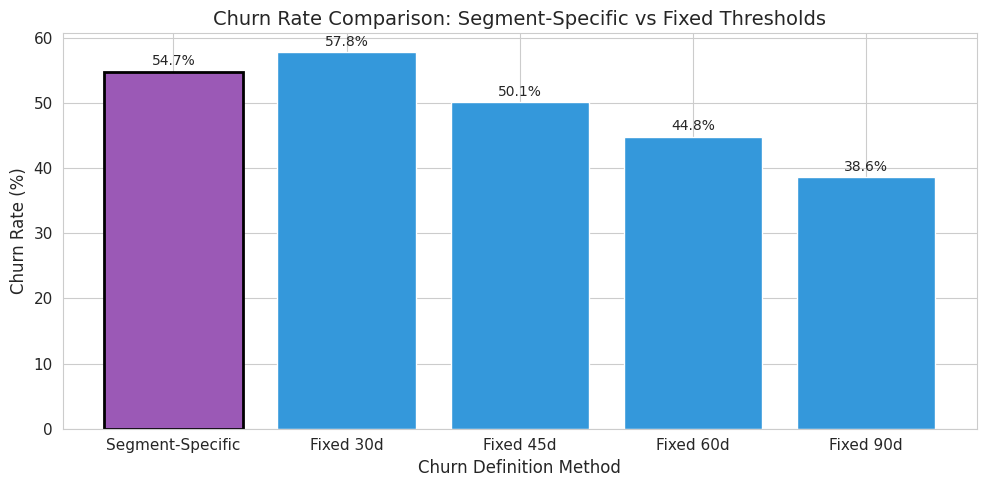

In [20]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 5))

colors = ['#9B59B6'] + ['#3498DB'] * len(fixed_thresholds)  # Purple for segment-specific
bars = ax.bar(comparison_df['Method'], comparison_df['Churn Rate'], color=colors)

ax.set_xlabel('Churn Definition Method')
ax.set_ylabel('Churn Rate (%)')
ax.set_title('Churn Rate Comparison: Segment-Specific vs Fixed Thresholds')

for bar, rate in zip(bars, comparison_df['Churn Rate']):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
            f'{rate:.1f}%', ha='center', fontsize=10)

# Highlight segment-specific
bars[0].set_edgecolor('black')
bars[0].set_linewidth(2)

plt.tight_layout()
plt.show()

---
## 8️⃣ Analyze Acquisition Cohort Effect

In [21]:
# Churn rate by acquisition month and segment
print('='*70)
print('📊 Churn Rate by Acquisition Cohort')
print('='*70)

cohort_churn = user_features.groupby('acquisition_month').agg(
    total_users=('user_id', 'count'),
    churned=('is_churned', 'sum')
).reset_index()

cohort_churn['churn_rate'] = (cohort_churn['churned'] / cohort_churn['total_users'] * 100).round(1)
cohort_churn = cohort_churn.sort_values('acquisition_month')

display(cohort_churn)

📊 Churn Rate by Acquisition Cohort


,acquisition_month,total_users,churned,churn_rate
0,1403-12,40042,17878,44.60
1,1404-01,113808,67856,59.60
2,1404-02,79834,56414,70.70
3,1404-03,50673,39212,77.40
4,1404-04,26158,18703,71.50
5,1404-05,39846,5736,14.40
6,1404-06,25637,0,0.00


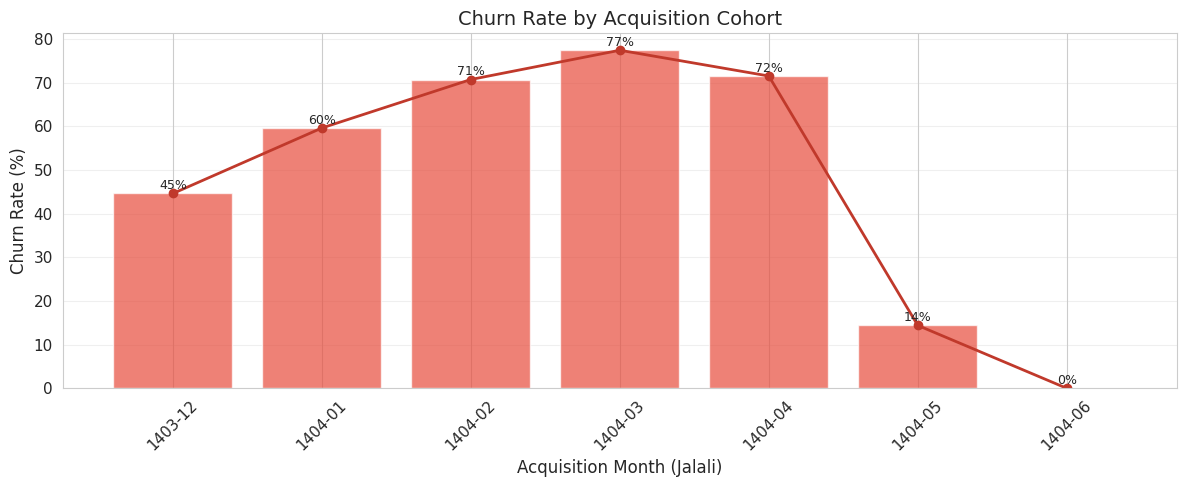

In [22]:
# Visualize cohort churn
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(cohort_churn['acquisition_month'], cohort_churn['churn_rate'], color='#E74C3C', alpha=0.7)
ax.plot(cohort_churn['acquisition_month'], cohort_churn['churn_rate'], 'o-', color='#C0392B', linewidth=2)

ax.set_xlabel('Acquisition Month (Jalali)')
ax.set_ylabel('Churn Rate (%)')
ax.set_title('Churn Rate by Acquisition Cohort')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

for i, row in cohort_churn.iterrows():
    ax.text(row['acquisition_month'], row['churn_rate'] + 1, 
            f"{row['churn_rate']:.0f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [23]:
# Churn rate heatmap: Segment × Cohort
print('='*70)
print('📊 Churn Rate Heatmap: Segment × Acquisition Cohort')
print('='*70)

# Create pivot table
cohort_segment_churn = user_features.groupby(['acquisition_month', 'frequency_segment']).agg(
    total=('user_id', 'count'),
    churned=('is_churned', 'sum')
).reset_index()

cohort_segment_churn['churn_rate'] = (cohort_segment_churn['churned'] / cohort_segment_churn['total'] * 100).round(1)

# Pivot for heatmap
pivot_churn = cohort_segment_churn.pivot(
    index='acquisition_month', 
    columns='frequency_segment', 
    values='churn_rate'
)

display(pivot_churn)

📊 Churn Rate Heatmap: Segment × Acquisition Cohort


frequency_segment,1 Order,2-4 Orders,5-10 Orders,11-30 Orders,30+ Orders
acquisition_month,,,,,
1403-12,100.00,74.60,42.90,34.00,12.50
1404-01,100.00,70.00,37.10,30.90,12.20
1404-02,100.00,62.30,29.80,27.80,14.80
1404-03,100.00,60.80,25.90,25.00,12.70
1404-04,100.00,42.10,12.60,15.20,4.30
1404-05,17.60,8.60,1.70,5.90,3.70
1404-06,0.00,0.00,0.00,0.00,0.00


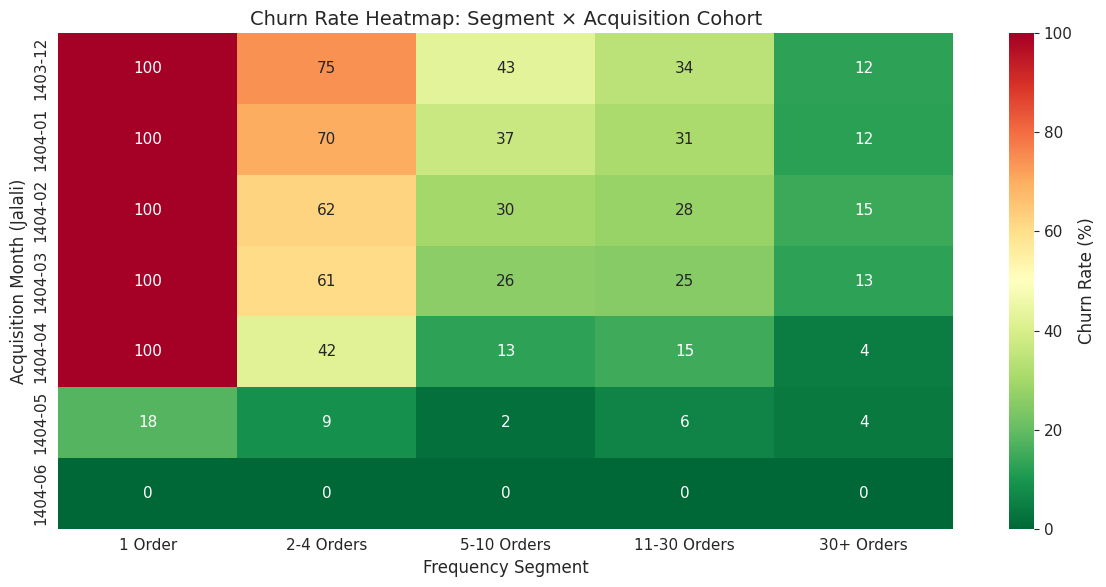

In [24]:
# Heatmap visualization
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(pivot_churn, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Churn Rate (%)'}, ax=ax,
            vmin=0, vmax=100)

ax.set_xlabel('Frequency Segment')
ax.set_ylabel('Acquisition Month (Jalali)')
ax.set_title('Churn Rate Heatmap: Segment × Acquisition Cohort')

plt.tight_layout()
plt.show()

---
## 9️⃣ Recency Analysis within Each Segment

In [25]:
# Recency distribution by segment
print('='*70)
print('📊 Recency Statistics by Segment')
print('='*70)

recency_stats = user_features.groupby('frequency_segment')['recency'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max',
     lambda x: x.quantile(0.25),
     lambda x: x.quantile(0.75)]
).round(1)

recency_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'P25', 'P75']
display(recency_stats)

📊 Recency Statistics by Segment


,Count,Mean,Median,Std,Min,Max,P25,P75
frequency_segment,,,,,,,,
1 Order,168769,95.60,107.00,53.70,0,180,45.00,141.00
2-4 Orders,83619,65.50,48.00,53.30,0,180,18.00,111.00
5-10 Orders,55972,35.50,20.00,39.20,0,180,7.00,48.00
11-30 Orders,48491,17.90,8.00,25.40,0,180,3.00,21.00
30+ Orders,19147,7.40,3.00,15.20,0,172,1.00,7.00


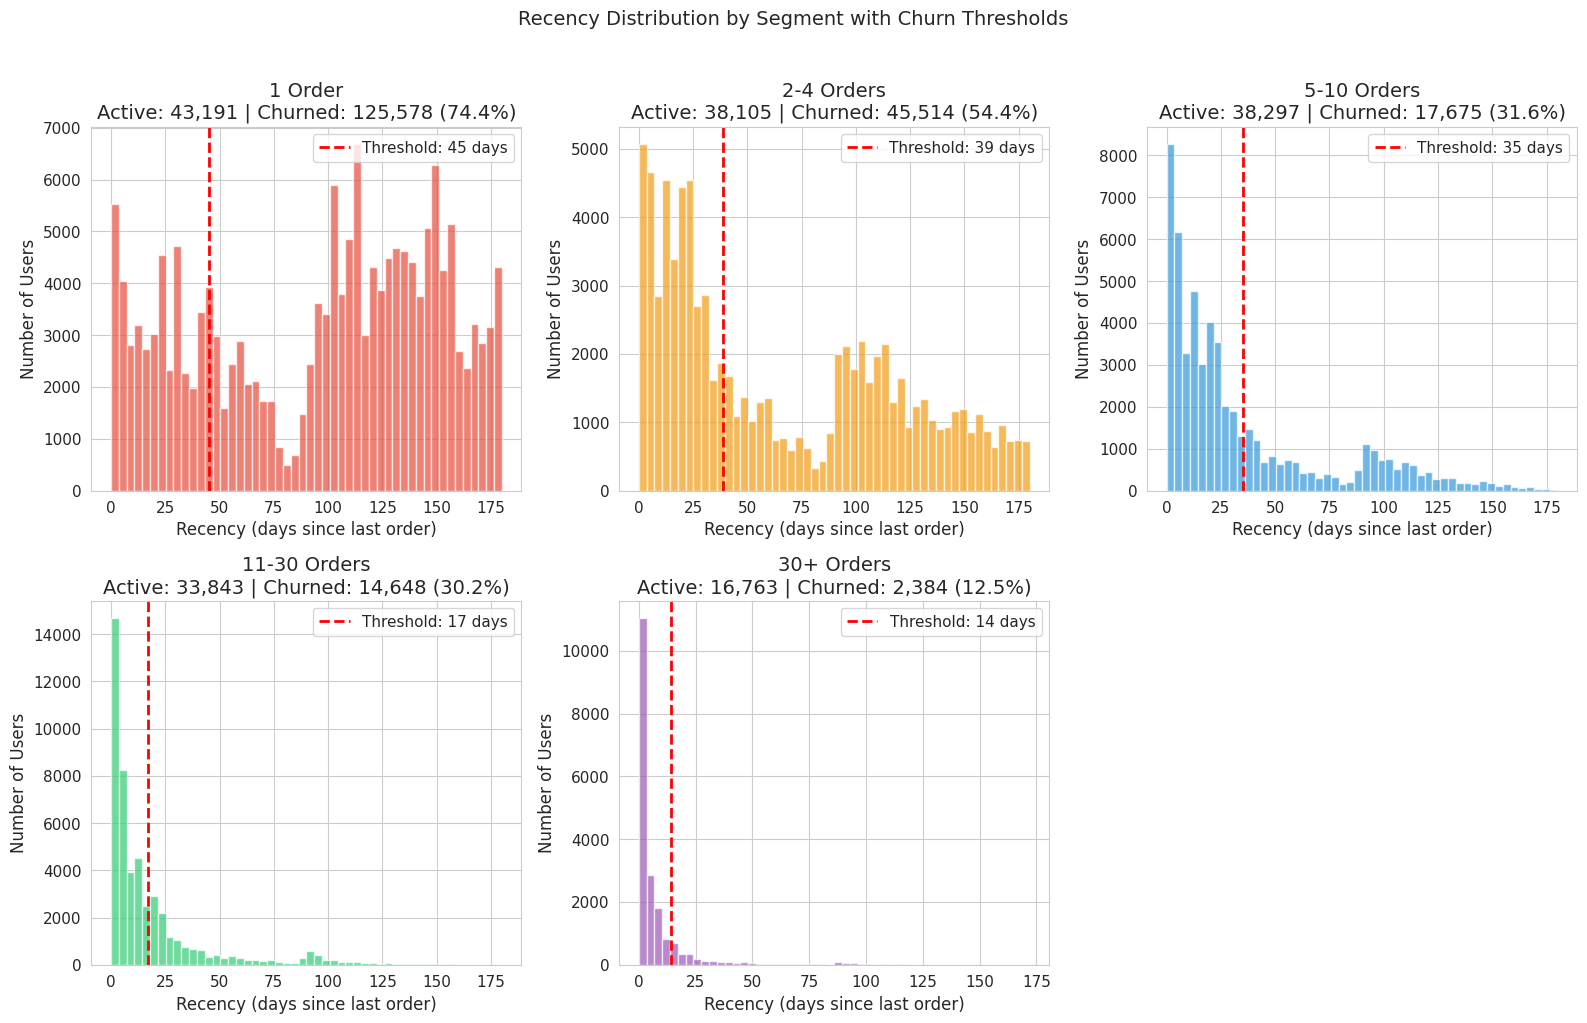

In [26]:
# Visualize recency distribution by segment
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, segment in enumerate(segment_order):
    ax = axes[idx]
    segment_data = user_features[user_features['frequency_segment'] == segment]['recency']
    threshold = final_thresholds[segment]
    
    ax.hist(segment_data, bins=50, color=SEGMENT_COLORS[segment], edgecolor='white', alpha=0.7)
    ax.axvline(x=threshold, color='red', linestyle='--', linewidth=2, 
               label=f'Threshold: {threshold:.0f} days')
    
    # Count churned vs active
    churned = (segment_data > threshold).sum()
    active = len(segment_data) - churned
    churn_rate = churned / len(segment_data) * 100
    
    ax.set_xlabel('Recency (days since last order)')
    ax.set_ylabel('Number of Users')
    ax.set_title(f'{segment}\nActive: {active:,} | Churned: {churned:,} ({churn_rate:.1f}%)')
    ax.legend(loc='upper right')

# Hide the 6th subplot if not needed
axes[5].axis('off')

plt.suptitle('Recency Distribution by Segment with Churn Thresholds', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## 🔟 Summary & Recommendations

In [27]:
print('='*70)
print('📋 SUMMARY: Segment-Specific Churn Definition')
print('='*70)

print('''
🎯 FINAL CHURN THRESHOLDS:
''')

for segment in segment_order:
    threshold = final_thresholds[segment]
    segment_data = churn_by_segment[churn_by_segment['frequency_segment'] == segment].iloc[0]
    print(f'  {segment:>15}: {threshold:>3.0f} days → Churn Rate: {segment_data["churn_rate"]:>5.1f}%')

print(f'''
📊 OVERALL RESULTS:
  Total Users:          {total_users:,}
  Active Users:         {total_active:,} ({100-overall_churn_rate:.1f}%)
  Churned Users:        {total_churned:,} ({overall_churn_rate:.1f}%)

💡 KEY INSIGHTS:
  1. Power users (30+ orders) have shorter threshold ({final_thresholds["30+ Orders"]:.0f}d) - they buy frequently
  2. Low-frequency users (2-4 orders) have longer threshold ({final_thresholds["2-4 Orders"]:.0f}d) - they buy less often
  3. One-time buyers use fixed threshold ({final_thresholds["1 Order"]:.0f}d) - no purchase history to learn from
  4. This approach is more fair and accurate than one-size-fits-all threshold

⚠️ CAVEATS:
  - Newer cohorts may have artificially high churn (not enough time to return)
  - One-time buyers might just be "not yet returned" rather than churned
  - Consider using prediction model instead of threshold-based definition
''')

📋 SUMMARY: Segment-Specific Churn Definition

🎯 FINAL CHURN THRESHOLDS:

          1 Order:  45 days → Churn Rate:  74.4%
       2-4 Orders:  39 days → Churn Rate:  54.4%
      5-10 Orders:  35 days → Churn Rate:  31.6%
     11-30 Orders:  17 days → Churn Rate:  30.2%
       30+ Orders:  14 days → Churn Rate:  12.5%

📊 OVERALL RESULTS:
  Total Users:          375,998
  Active Users:         170,199 (45.3%)
  Churned Users:        205,799 (54.7%)

💡 KEY INSIGHTS:
  1. Power users (30+ orders) have shorter threshold (14d) - they buy frequently
  2. Low-frequency users (2-4 orders) have longer threshold (39d) - they buy less often
  3. One-time buyers use fixed threshold (45d) - no purchase history to learn from
  4. This approach is more fair and accurate than one-size-fits-all threshold

⚠️ CAVEATS:
  - Newer cohorts may have artificially high churn (not enough time to return)
  - One-time buyers might just be "not yet returned" rather than churned
  - Consider using prediction model in

In [28]:
# Save user features with churn labels
output_path = '../data/user_features_segment_churn.csv'
user_features.to_csv(output_path, index=False)
print(f'✅ User features saved to: {output_path}')

# Display sample
print('\n📊 Sample of final dataset:')
display(user_features[['user_id', 'order_count', 'frequency_segment', 'avg_purchase_interval', 
                       'recency', 'churn_threshold', 'is_churned', 'acquisition_month']].head(20))

✅ User features saved to: ../data/user_features_segment_churn.csv

📊 Sample of final dataset:


,user_id,order_count,frequency_segment,avg_purchase_interval,recency,churn_threshold,is_churned,acquisition_month
0,1,25,11-30 Orders,6.62,10,17.06,False,1404-01
1,4,2,2-4 Orders,107.00,25,38.67,False,1404-02
2,14,4,2-4 Orders,5.67,12,38.67,False,1404-05
3,16,3,2-4 Orders,37.50,25,38.67,False,1404-03
4,40,35,30+ Orders,4.76,6,14.00,False,1404-01
5,41,2,2-4 Orders,83.00,35,38.67,False,1404-02
6,42,4,2-4 Orders,49.00,2,38.67,False,1404-01
7,60,24,11-30 Orders,6.96,17,17.06,False,1403-12
8,63,12,11-30 Orders,14.27,3,17.06,False,1404-01
9,66,2,2-4 Orders,8.00,127,38.67,True,1404-02
